In [3]:
from canns.models.basic.theta_sweep_model import (
    DirectionCellNetwork,
    GridCellNetwork,
    calculate_theta_modulation
)

# Create head direction network
dc_net = DirectionCellNetwork(
    num=100,                   # Number of direction cells
    adaptation_strength=15.0,  # Spike-frequency adaptation
    noise_strength=0.0        # Activity noise
)

# Create grid cell network
gc_net = GridCellNetwork(
    num_dc=100,               # Direction cells (matches dc_net)
    num_gc_x=100,             # Grid cells per dimension
    adaptation_strength=25.0,  # Strong SFA for clear theta sweeps
    mapping_ratio=10,         # Controls grid spacing
    noise_strength=0.0
)

<OpenLoopNavigationTask>Generating Task data: 100%|██████████| 2000/2000 [00:00<00:00, 569027.81it/s]

Trajectory: 2000 steps
Duration: 2.0s


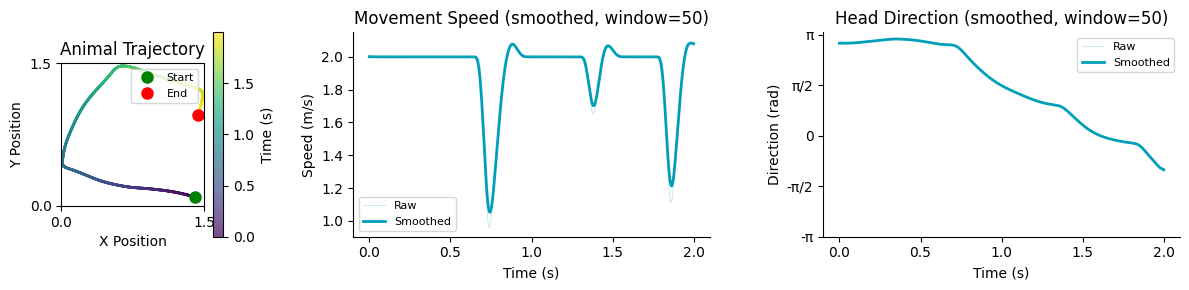

In [4]:
import numpy as np
import brainpy.math as bm
from canns.task.open_loop_navigation import OpenLoopNavigationTask
from canns.models.basic.theta_sweep_model import (
    DirectionCellNetwork,
    GridCellNetwork,
    calculate_theta_modulation
)

# Setup
np.random.seed(10)
env_size = 1.5  # meters
simulate_time = 2.0  # seconds
dt = 0.001  # seconds for navigation task

bm.set_dt(1.0)  # 1 ms for neural simulation

# Create navigation task
task = OpenLoopNavigationTask(
    duration=simulate_time,
    initial_head_direction=11/12 * bm.pi,  # Starting angle
    width=env_size,
    height=env_size,
    start_pos=[env_size * 15/16, env_size * 1/16],  # Top-right corner
    speed_mean=2.0,           # m/s
    speed_std=0.0,            # Constant speed
    dt=dt,
    speed_coherence_time=10,
    rotational_velocity_std=40 * np.pi / 180,  # 40 deg/s std
)

# Generate trajectory
task.get_data()

# IMPORTANT: Calculate theta sweep parameters
task.calculate_theta_sweep_data()

print(f"Trajectory: {task.total_steps} steps")
print(f"Duration: {simulate_time}s")

task.show_trajectory_analysis()

In [5]:
# Create direction cell network
dc_net = DirectionCellNetwork(
    num=100,
    adaptation_strength=15,  # Strong SFA for clear theta
    noise_strength=0.0,      # No noise for clean demo
)

# Create grid cell network
mapping_ratio = 10  # Controls grid spacing
gc_net = GridCellNetwork(
    num_dc=dc_net.num,
    num_gc_x=100,
    adaptation_strength=25,  # Strong SFA
    mapping_ratio=mapping_ratio,
    noise_strength=0.0,
)

print(f"Direction cells: {dc_net.num}")
print(f"Grid cells: {gc_net.num_gc_1side} x {gc_net.num_gc_1side}")

Direction cells: 100
Grid cells: 100 x 100


In [6]:
# Extract task data
position = task.data.position
direction = task.data.hd_angle
linear_speed_gains = task.data.linear_speed_gains
ang_speed_gains = task.data.ang_speed_gains

def run_step(i, pos, hd_angle, linear_gain, ang_gain):
    """Single step with theta modulation"""

    # Calculate theta phase and modulation
    theta_phase, theta_mod_hd, theta_mod_gc = calculate_theta_modulation(
        time_step=i,
        linear_gain=linear_gain,      # Forward speed influence
        ang_gain=ang_gain,             # Turning speed influence
        theta_strength_hd=1.0,         # HD theta modulation strength
        theta_strength_gc=1.0,         # Grid theta modulation strength
        theta_cycle_len=100.0,         # Theta cycle = 100 ms (bm.dt=1 ms)
        dt=None,
    )

    # Update direction cells with theta modulation
    dc_net(hd_angle, theta_mod_hd)
    dc_activity = dc_net.r.value

    # Update grid cells with direction input and theta modulation
    gc_net(pos, dc_activity, theta_mod_gc)
    gc_activity = gc_net.r.value

    # Return state for analysis
    return (
        gc_net.center_position.value,  # Decoded grid position
        dc_net.center.value,            # Decoded head direction
        gc_activity,                     # Grid cell activities
        gc_net.gc_bump.value,           # Grid bump state
        dc_activity,                     # Direction cell activities
        theta_phase,                     # Current theta phase
        theta_mod_hd,                    # HD theta modulation
        theta_mod_gc,                    # Grid theta modulation
    )

# Run simulation
print("Running theta-modulated simulation...")
results = bm.for_loop(
    run_step,
    operands=(
        bm.arange(len(position)),
        position,
        direction,
        linear_speed_gains,
        ang_speed_gains,
    ),
    progress_bar=10,
)

# Unpack results
(
    internal_position,
    internal_direction,
    gc_activity,
    gc_bump,
    dc_activity,
    theta_phase,
    theta_mod_hd,
    theta_mod_gc,
) = results

print("Simulation complete!")
print(f"Internal position tracking shape: {internal_position.shape}")
print(f"Grid cell activity shape: {gc_activity.shape}")

Running theta-modulated simulation...


  0%|          | 0/2000 [00:00<?, ?it/s]

Simulation complete!
Internal position tracking shape: (2000, 2)
Grid cell activity shape: (2000, 10000)


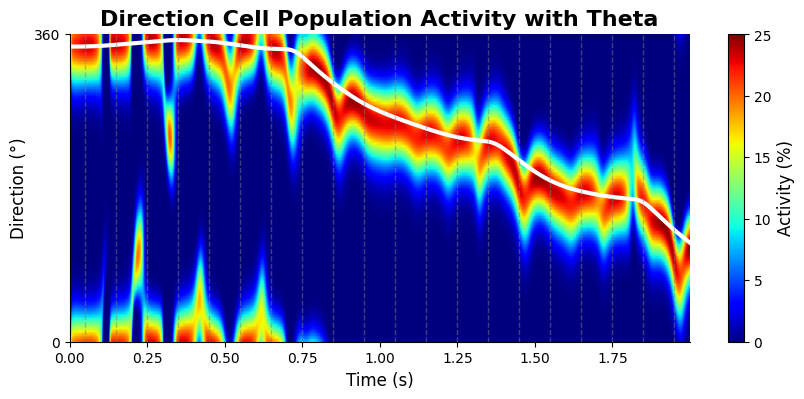

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'Direction Cell Population Activity with Theta'}, xlabel='Time (s)', ylabel='Direction (°)'>)

In [7]:
from canns.analyzer.visualization.theta_sweep_plots import plot_population_activity_with_theta
from canns.analyzer.visualization import PlotConfigs

# Configure plot
config_pop = PlotConfigs.theta_population_activity_static(
    title="Direction Cell Population Activity with Theta",
    xlabel="Time (s)",
    ylabel="Direction (°)",
    figsize=(10, 4),
    show=True,
    save_path=None
)

# Plot population activity
plot_population_activity_with_theta(
    time_steps=task.run_steps * dt,  # Convert to seconds
    theta_phase=theta_phase,
    net_activity=dc_activity,
    direction=direction,
    config=config_pop,
    add_lines=True,     # Add theta phase lines
    atol=5e-2,          # Tolerance for line detection
)

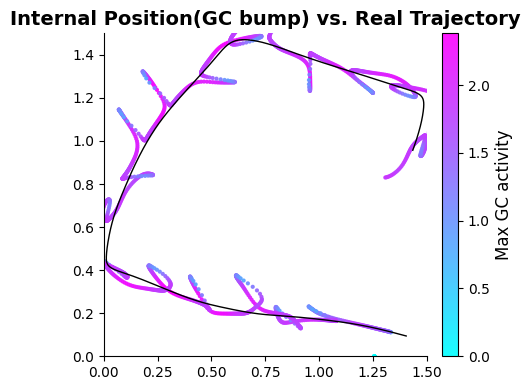

(<Figure size 500x400 with 2 Axes>,
 <Axes: title={'center': 'Internal Position(GC bump) vs. Real Trajectory'}>)

In [10]:
from canns.analyzer.visualization.theta_sweep_plots import plot_internal_position_trajectory

# Plot internal position vs. real trajectory
max_gc_activity = np.max(gc_activity, axis=1)
config_internal = PlotConfigs.internal_position_trajectory_static(
    title="Internal Position(GC bump) vs. Real Trajectory",
    figsize=(5, 4),
    show=True,
    save_path=None
)

plot_internal_position_trajectory(
    internal_position=internal_position,
    position=position,
    max_activity=max_gc_activity,
    env_size=env_size,
    config=config_internal,
)


/var/folders/x0/_jqxxbbn0rsdn6b4h6fxbrjr0000gn/T/ipykernel_99958/1711234182.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  value_grid_twisted = np.dot(


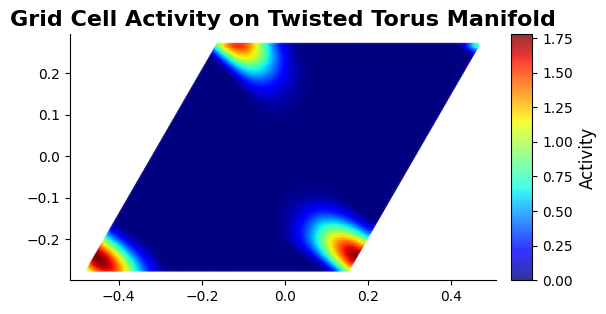

(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Grid Cell Activity on Twisted Torus Manifold'}>)

In [11]:
from canns.analyzer.visualization.theta_sweep_plots import plot_grid_cell_manifold

# Transform grid positions to twisted torus coordinates
value_grid_twisted = np.dot(
    gc_net.coor_transform_inv,
    gc_net.value_grid.T
).T

# Reshape grid cell activity
grid_cell_activity = gc_activity.reshape(
    -1,
    gc_net.num_gc_1side,
    gc_net.num_gc_1side
)

# Select a frame to visualize
frame_idx = 900

# Configure plot
config_manifold = PlotConfigs.grid_cell_manifold_static(
    title="Grid Cell Activity on Twisted Torus Manifold",
    figsize=(6, 5),
    show=True,
    save_path=None
)

# Plot manifold
plot_grid_cell_manifold(
    value_grid_twisted=value_grid_twisted / mapping_ratio,
    grid_cell_activity=grid_cell_activity[frame_idx],
    config=config_manifold,
)

In [ ]:
from canns.analyzer.visualization.theta_sweep_plots import create_theta_sweep_grid_cell_animation

# Configure animation
config_anim = PlotConfigs.theta_sweep_animation(
    figsize=(12, 3),
    fps=10,
    show=True,
    save_path="theta_sweep_grid_cell_animation.mp4",
)

# Create animation
animation = create_theta_sweep_grid_cell_animation(
    position_data=position,
    direction_data=direction,
    dc_activity_data=dc_activity,
    gc_activity_data=gc_activity,
    gc_network=gc_net,
    env_size=env_size,
    mapping_ratio=mapping_ratio,
    dt=dt,
    config=config_anim,
    n_step=10,                # Sample every 10 frames
    show_progress_bar=True,
    render_backend="auto",    # Automatically choose best backend
    output_dpi=120,
)